- In this default run the lake is fomed on day 363 
- It disppears on day 675 and never returns
- combine_lid_firn function is called which
- 'Combines the lid and firn profiles into a single column when the lake is completely frozen.'
- The lake is integrated into the firn and flags reset 
- cell["lake"] = False
- cell["lake_depth"] = 0.0 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm

expt_id = 'era5_2013_2024_01'
start_time = pd.Timestamp('2013-01-01 00:00')

output_filepath = '1d_testcase_output_' + expt_id + '.nc' 
dump_filepath   = '1d_testcase_dump_' + 'era5_2013_2024_01' + '.nc' 

output = nc.Dataset(output_filepath, 'r')
dump = nc.Dataset(dump_filepath, 'r')

In [2]:
vertical_depth = dump.variables['vertical_profile'][0:,0, :]
vertical_depth = vertical_depth.squeeze() 

# check when/if a lake is formed
lake = output.variables['lake'][:, 0, 0]

# set up time in days
time_day = pd.date_range(start=start_time, periods=len(lake), freq='d')

islake = np.where(lake == 1)[0]

if islake.size > 0:
    start_lake_index = islake[0]
    end_lake_index = islake[-1] + 1
else:
    print('Lake did not form.')

print(start_lake_index, end_lake_index)

363 675


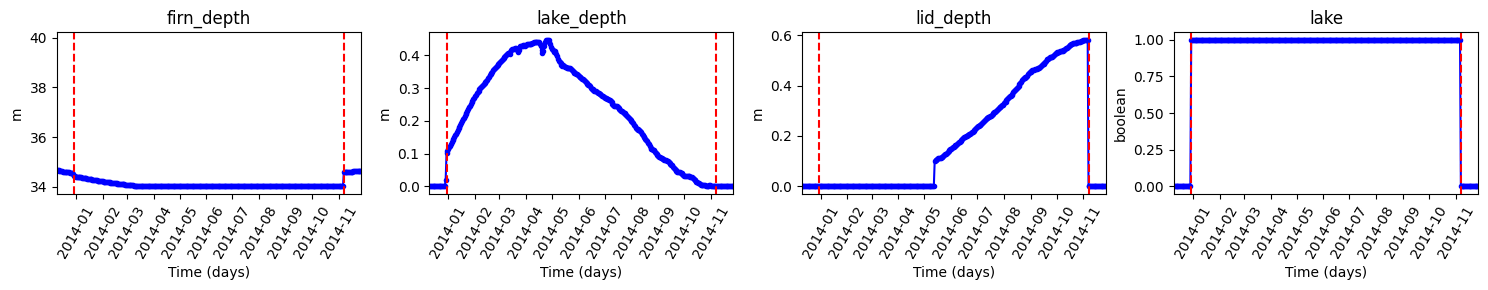

In [3]:
firn_1d_vars = ['firn_depth', 'lake_depth', 'lid_depth','lake']
firn_1d_units = ['m', 'm', 'm' ,'boolean']

time_day = pd.date_range(start=start_time, periods=len(lake), freq='d')

fig, axes = plt.subplots(1, 4, figsize=(15, 3)) # w, h
axes = axes.flatten()

for i, var_name in enumerate(firn_1d_vars):
    ax = axes[i]
    data = output.variables[var_name][:, 0, 0]
    time = np.arange(len(data))
    
    ax.plot(time_day, data, 'b.-')
    ax.set_title(var_name)
    ax.set_ylabel(firn_1d_units[i])
    ax.set_xlabel('Time (days)')
    ax.axvline(x=time_day[start_lake_index], color='red', linestyle='--', linewidth=1.5) 
    
    ax.axvline(x=time_day[end_lake_index], color='red', linestyle='--', linewidth=1.5) 
    
    ax.set_xlim(time_day[start_lake_index-20], time_day[end_lake_index+20])
    ax.tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.show()


C:\Users\ik933917\AppData\Local\Temp\ipykernel_18144\3047642217.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap('jet', 256)


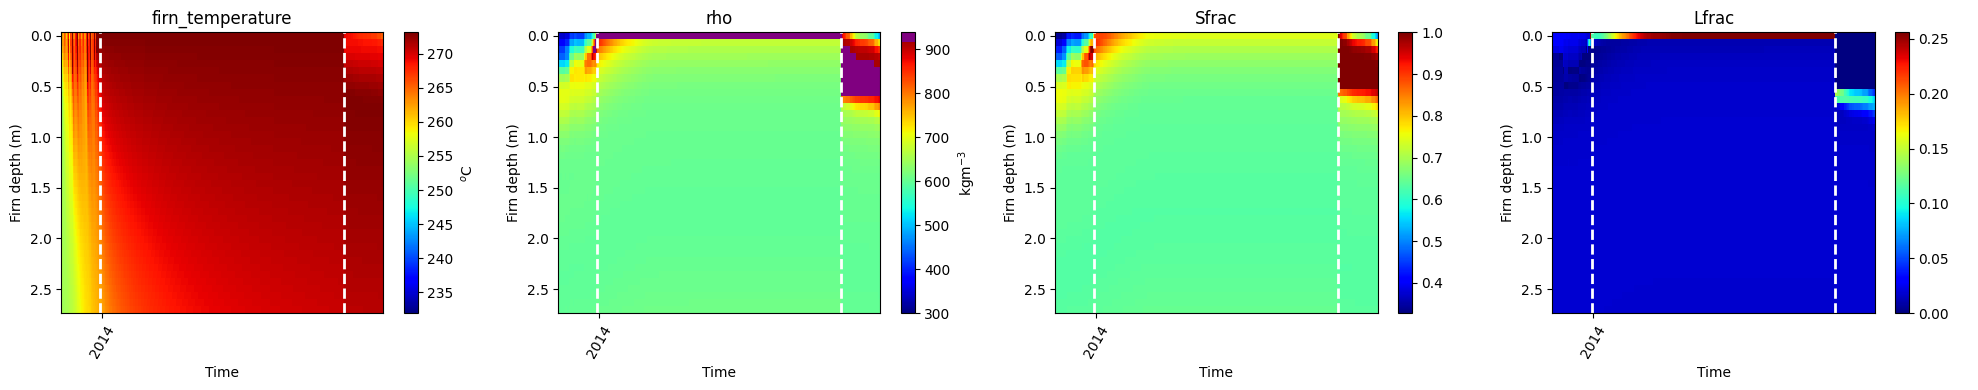

In [4]:

# 2d variables
firn_2d_vars  = ['firn_temperature', 'rho',     'Sfrac', 'Lfrac' ]
firn_2d_units = ['$^{o}$C',          'kgm$^{-3}$', ' ', ' ' ]

# [0:40 levels]
firn_2d_min   = [231.89580782, 299.9999, 0.327153, 0]
firn_2d_max   = [ 273.15, 938.227, 1, 0.255755]


fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()



for i, var_name in enumerate(firn_2d_vars):
    ax = axes[i]
    data_2d = output.variables[var_name][:, 0, 0, :] #[1:, 0, 0, :]  # skip timestep 0 because of netCDF bug
    
    #vmin = np.min(data_2d.T[0:40,:][data_2d.T[0:40,:] != 0])
    #vmax = np.max(data_2d.T[0:40,:])
    
    # set values > 917kg/m3 to purple. slushy watery
    if var_name == 'rho':
        
        base_cmap = cm.get_cmap('jet', 256)
        
        newcolors = base_cmap(np.linspace(0, 1, 256))
        threshold_norm = (917.00001 - firn_2d_min[i]) / (firn_2d_max[i] - firn_2d_min[i])
        threshold_index = int(np.clip(threshold_norm * 256, 0, 255))

        newcolors[threshold_index:] = [0.5, 0.0, 0.5, 1.0]  # RGBA for purple

        custom_cmap = mcolors.ListedColormap(newcolors)
        
        cmap_to_use = custom_cmap
    else:
        cmap_to_use = 'jet'

    im = ax.pcolormesh(time_day, vertical_depth[0:40], data_2d.T[0:40,:], shading='auto', 
                       cmap=cmap_to_use, vmin=firn_2d_min[i],vmax=firn_2d_max[i])
    
    
    ax.axvline(x=time_day[start_lake_index], color='white', linestyle='--', linewidth=2)
    ax.axvline(x=time_day[end_lake_index], color='white', linestyle='--', linewidth=2) 
    plt.colorbar(im, ax=ax, label=firn_2d_units[i])
    ax.set_title(var_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Firn depth (m)')
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlim(time_day[start_lake_index-50], time_day[end_lake_index+50])
    
plt.tight_layout()
plt.show()



In [6]:
#print(output.variables['rho'][start_lake_index:end_lake_index+3,0,0, 0])
#print('model level nearest surface is slush rho > 917kg/m3')

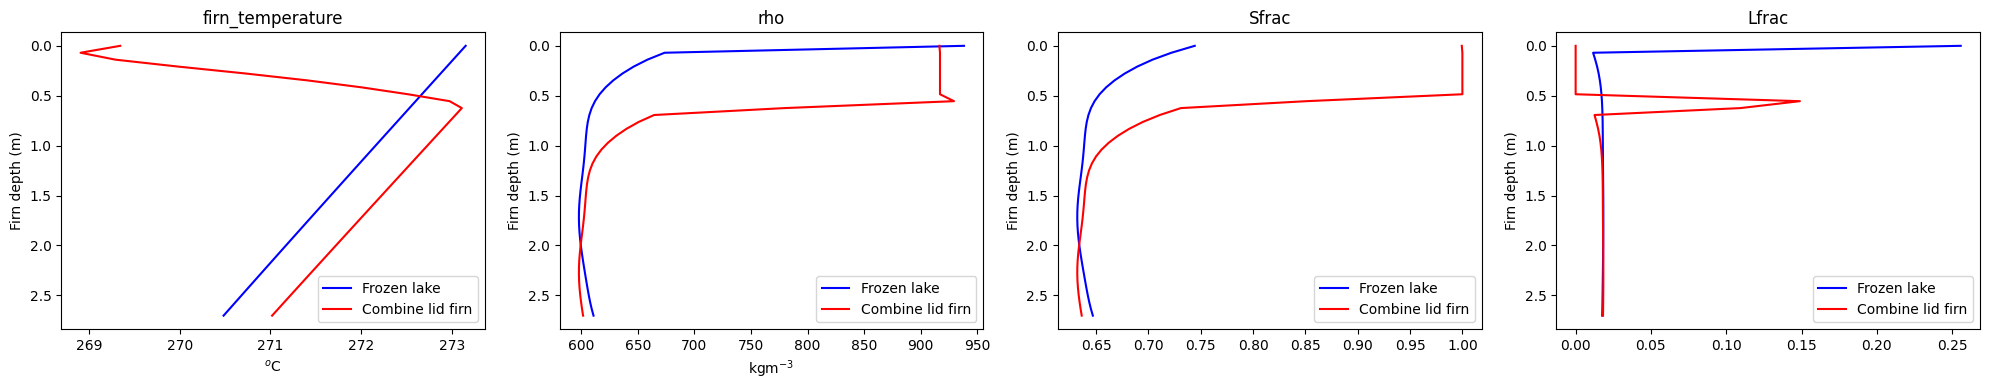

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()

for i, var_name in enumerate(firn_2d_vars):
    ax = axes[i]
    profile_end = output.variables[var_name][end_lake_index, 0, 0, 0:40]
    profile_end_minus_1 = output.variables[var_name][end_lake_index-1, 0, 0, 0:40]
    ax.plot(profile_end_minus_1, vertical_depth[0:40], label='Frozen lake', color='blue')
    ax.plot(profile_end, vertical_depth[0:40], label='Combine lid firn', color='red')
    ax.set_title(var_name)
    ax.set_xlabel(f'{firn_2d_units[i]}')
    ax.set_ylabel('Firn depth (m)')
    ax.invert_yaxis()
    ax.legend()
    
plt.tight_layout()
plt.show()


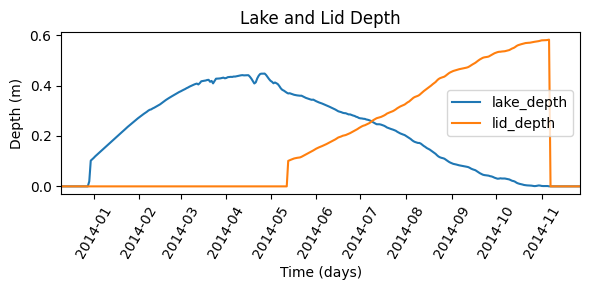

Max lake depth: 0.45 m
Max lid depth: 0.58 m


In [9]:
lake_vars = ['lake_depth', 'lid_depth']
lake_units = ['m', 'm']

time_day = pd.date_range(start=start_time, periods=len(output.variables['lake_depth'][:, 0, 0]), freq='d')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for var_name, unit in zip(lake_vars, lake_units):
    data = output.variables[var_name][:, 0, 0]
    ax.plot(time_day, data, label=var_name)

ax.set_title('Lake and Lid Depth')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time (days)')
ax.set_xlim(time_day[start_lake_index-20], time_day[end_lake_index+20])
ax.tick_params(axis='x', rotation=60)
ax.legend()

plt.tight_layout()
plt.show()

lake_max = output.variables['lake_depth'][:, 0, 0].max()
lid_max = output.variables['lid_depth'][:, 0, 0].max()

print(f"Max lake depth: {lake_max:.2f} m")
print(f"Max lid depth: {lid_max:.2f} m")

rho_water = 1000
rho_ice   = 917
t1        = 498
t2        = 580
mass_t1 = output.variables['lake_depth'][t1, 0, 0] * rho_water + output.variables['lid_depth'][t1, 0, 0] * rho_ice


In [10]:
output.close()
dump.close()